# Inclusion Pipeline

Basic code to run the pipeline on a single CZI image.

In [73]:
# Install if needed (run once)
# !conda install -c conda-forge micro_sam
# !pip install git+https://github.com/sunghoojung/segment-classify-pipeline.git

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from czifile import imread
from inclusion_pipeline import SegmentClassifyPipeline, overlay_mask_on_image

## 1. Load and inspect image

In [75]:
# Load CZI image
image_path = "images/3K_dox_LAMP1rfp_mitoBFP_untreated_06.czi"  # Change to your image path
image = imread(image_path)

print(f"Raw shape: {image.shape}")
print(f"dtype: {image.dtype}")

Raw shape: (1, 1, 3, 1, 479, 479, 1)
dtype: uint16


In [76]:
# Squeeze and extract channels
image_squeezed = np.squeeze(image)
print(f"Squeezed shape: {image_squeezed.shape}")

# Extract channels: [C, H, W] -> orange, green, blue
orange, green, blue = image_squeezed[0], image_squeezed[1], image_squeezed[2]

print(f"Green channel shape: {green.shape}")
print(f"Green channel dtype: {green.dtype}")
print(f"Green channel min/max: {green.min()} / {green.max()}")

Squeezed shape: (3, 479, 479)
Green channel shape: (479, 479)
Green channel dtype: uint16
Green channel min/max: 45 / 65535


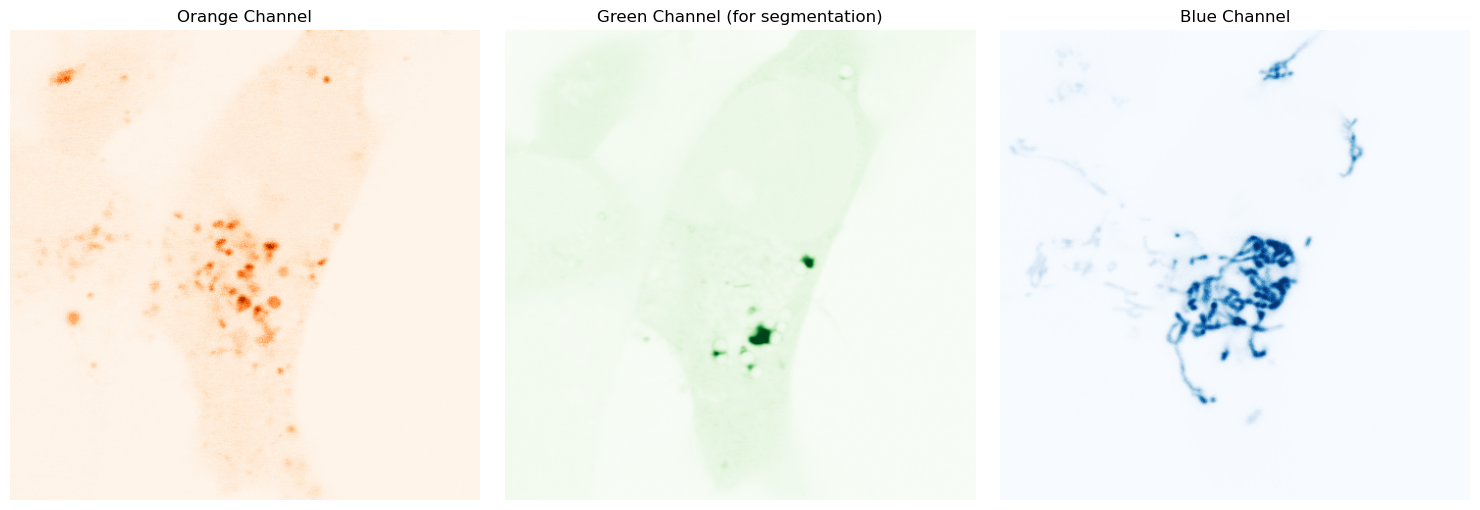

In [77]:
# Visualize the channels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(orange, cmap='Oranges')
axes[0].set_title('Orange Channel')
axes[0].axis('off')

axes[1].imshow(green, cmap='Greens')
axes[1].set_title('Green Channel (for segmentation)')
axes[1].axis('off')

axes[2].imshow(blue, cmap='Blues')
axes[2].set_title('Blue Channel')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 2. Initialize Pipeline

In [78]:
# Initialize pipeline (downloads weights on first run)
pipeline = SegmentClassifyPipeline()

Initializing pipeline on cpu...
Checkpoint downloaded to: C:\Users\sj1205\.cache\huggingface\hub\models--sunny17347--machine_learning_models\snapshots\1b29671ff123c66cffe07e6e7077c95cb55ad06e\inclusion_segmentation_12_3_25.pt
Initializing MicroSAM predictor and segmenter...
MicroSAM initialized!
Checkpoint downloaded to: C:\Users\sj1205\.cache\huggingface\hub\models--sunny17347--machine_learning_models\snapshots\1b29671ff123c66cffe07e6e7077c95cb55ad06e\inclusion_classifier_v1.pth
Initializing resnet101...
ResNet classifier initialized!
Pipeline ready!


## 3. Run Pipeline with Verbose Mode

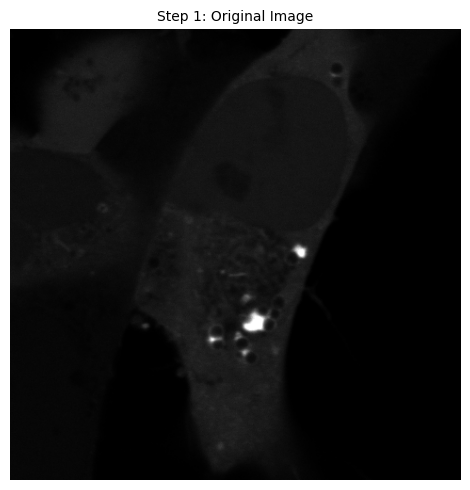

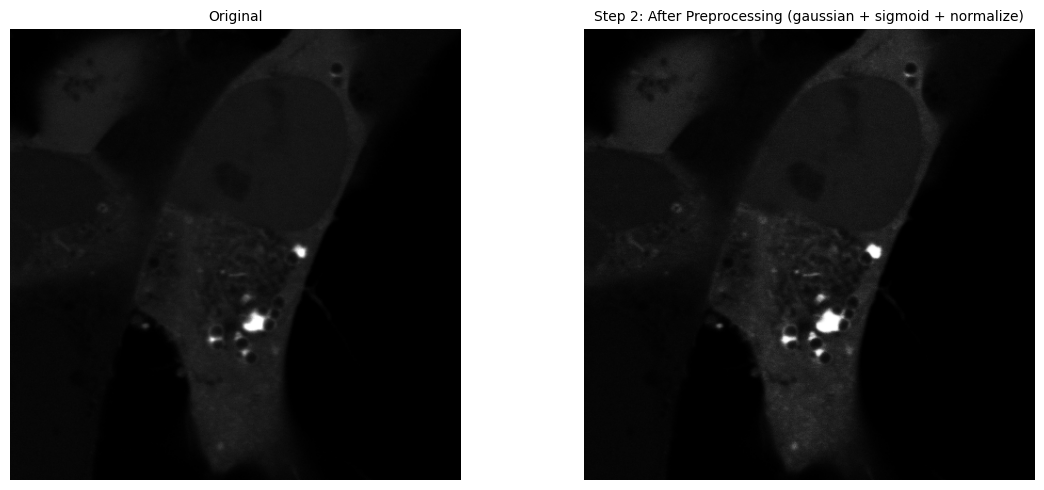

Step 3: Running MicroSAM segmentation...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


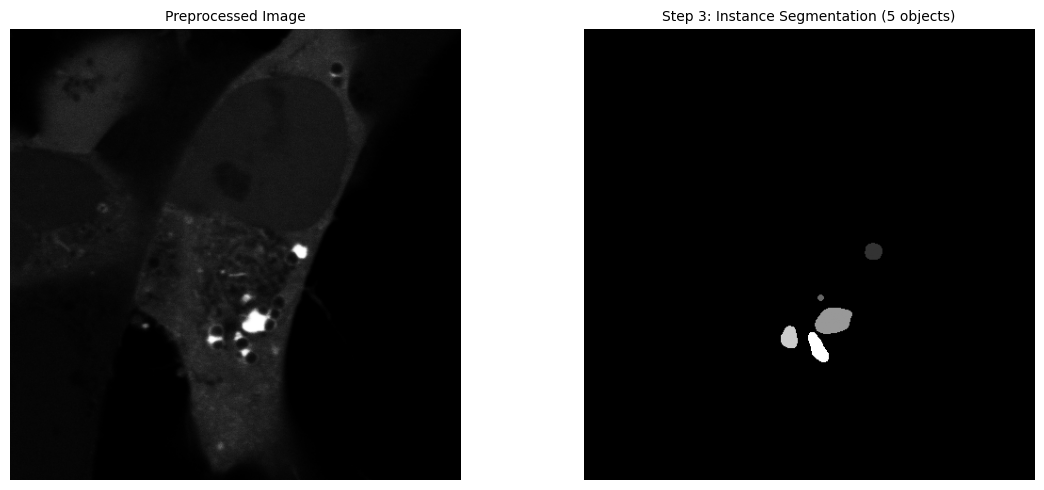

Step 4: Classifying 5 objects using regionprops...
  Object 1: swiss_cheese (area=274.0, crop_shape=(28, 29), crop_dtype=uint16, crop_min=2543.0, crop_max=65535.0, conf=0.999)


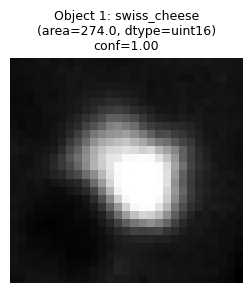

  Object 2: solid (area=37.0, crop_shape=(17, 17), crop_dtype=uint16, crop_min=3803.0, crop_max=26884.0, conf=0.640)


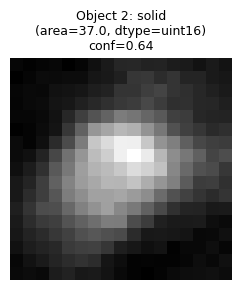

  Object 3: swiss_cheese (area=864.0, crop_shape=(38, 50), crop_dtype=uint16, crop_min=2108.0, crop_max=65535.0, conf=1.000)


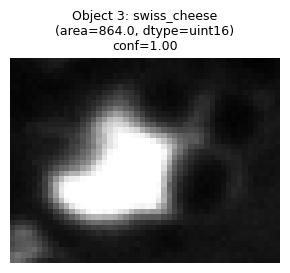

  Object 4: swiss_cheese (area=337.0, crop_shape=(34, 28), crop_dtype=uint16, crop_min=2460.0, crop_max=64206.0, conf=0.999)


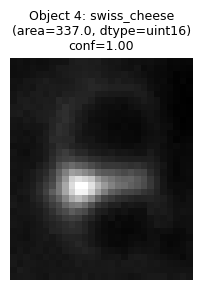

  Object 5: swiss_cheese (area=418.0, crop_shape=(42, 32), crop_dtype=uint16, crop_min=2609.0, crop_max=65535.0, conf=1.000)


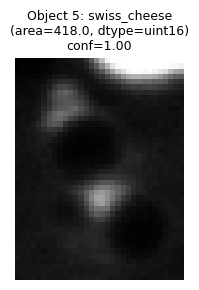


Step 5: Classification complete!
  Total objects classified: 5
  Swiss cheese: 4
  Solid: 1


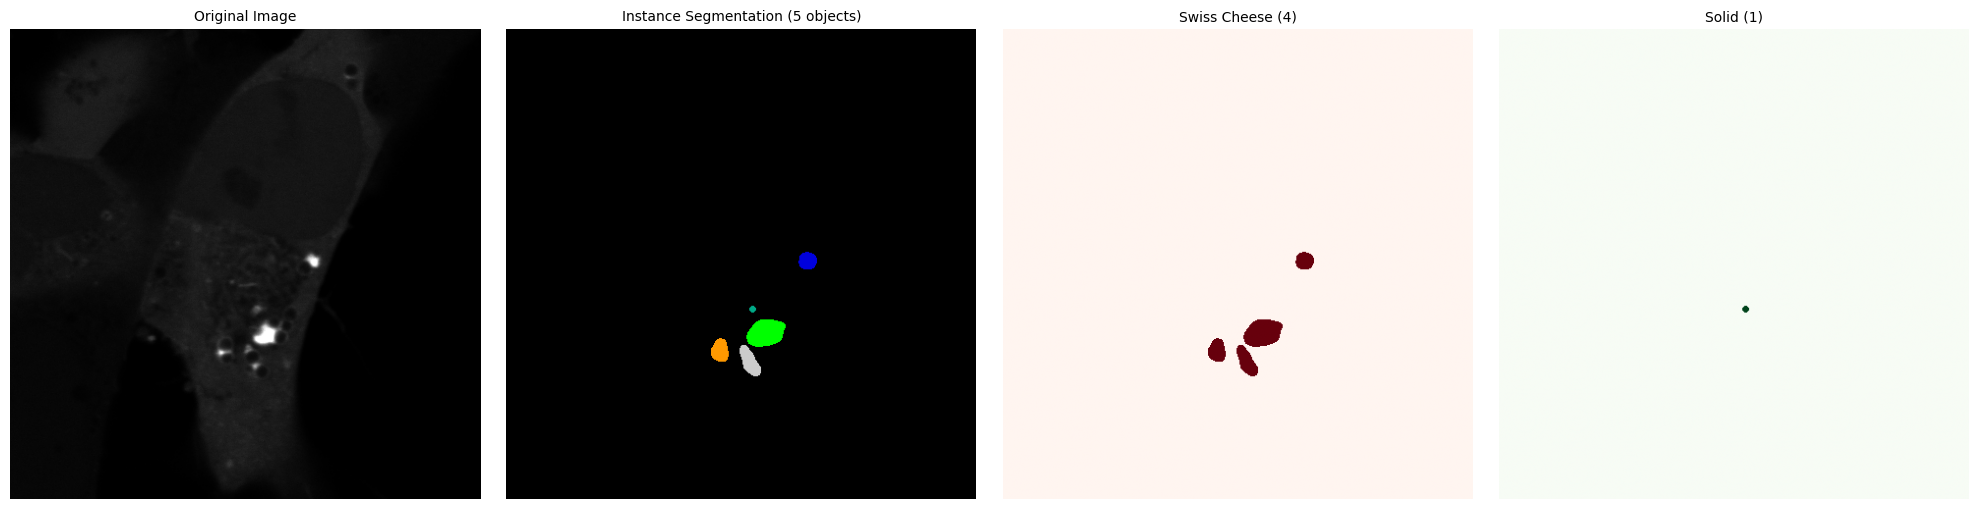

In [79]:
# Run on the green channel with verbose output
result = pipeline(green, verbose=True)

## 4. View Results

In [80]:
print(f"Total swiss cheese inclusions: {result.num_swiss_cheese}")
print(f"Total solid inclusions: {result.num_solid}")
print(f"Total objects classified: {len(result.instance_labels)}")

Total swiss cheese inclusions: 4
Total solid inclusions: 1
Total objects classified: 5


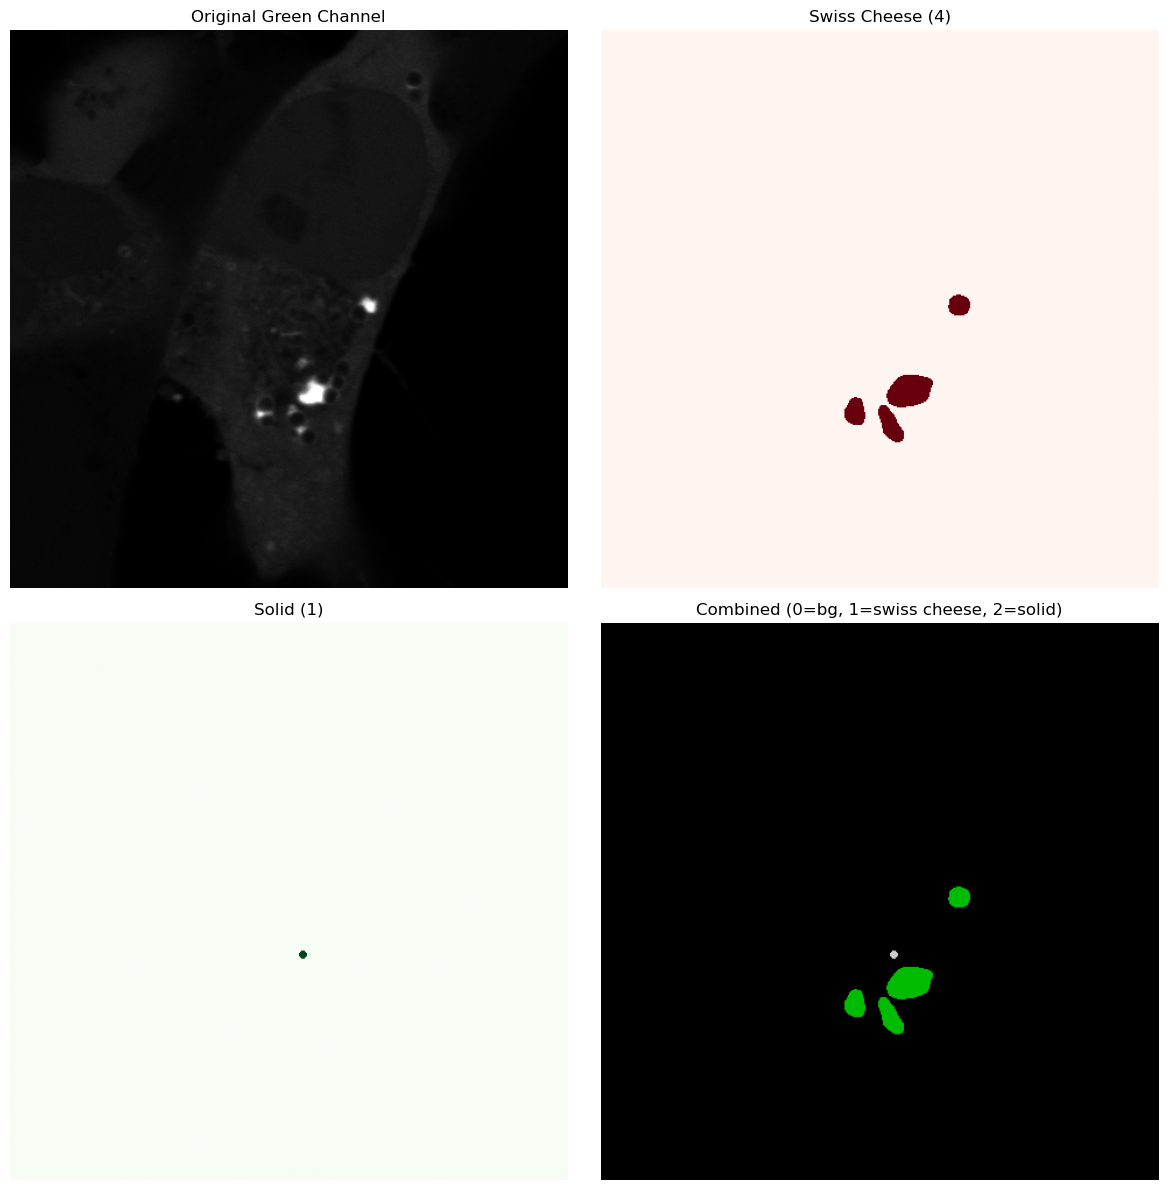

In [81]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original green channel
axes[0, 0].imshow(green, cmap='gray')
axes[0, 0].set_title('Original Green Channel')
axes[0, 0].axis('off')

# Inclusion mask
axes[0, 1].imshow(result.swiss_cheese_mask, cmap='Reds')
axes[0, 1].set_title(f'Swiss Cheese ({result.num_swiss_cheese})')
axes[0, 1].axis('off')

# Solid mask
axes[1, 0].imshow(result.solid_mask, cmap='Greens')
axes[1, 0].set_title(f'Solid ({result.num_solid})')
axes[1, 0].axis('off')

# Combined mask
axes[1, 1].imshow(result.combined_mask, cmap='nipy_spectral')
axes[1, 1].set_title('Combined (0=bg, 1=swiss cheese, 2=solid)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

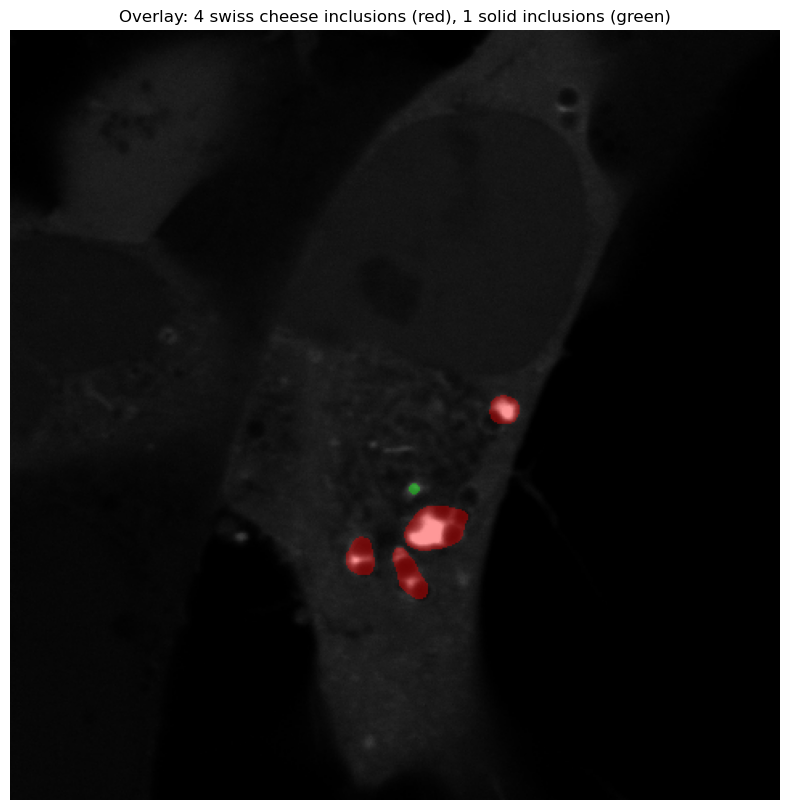

In [82]:
# Create overlay visualization
overlay = overlay_mask_on_image(
    green,
    result.combined_mask,
    swiss_cheese_color=(255, 0, 0),      # Red for swiss cheese inclusions
    solid_color=(0, 255, 0),  # Green for solid inclusions
    alpha=0.4
)

plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.title(f'Overlay: {result.num_swiss_cheese} swiss cheese inclusions (red), {result.num_solid} solid inclusions (green)')
plt.axis('off')
plt.show()

## 5. Optional: Inspect Individual Objects

In [83]:
# Loop through each detected object
for i, (mask, label) in enumerate(zip(result.instance_masks, result.instance_labels)):
    label_name = "Swiss cheese" if label == 1 else "Solid"
    area = mask.sum()
    print(f"Object {i+1}: {label_name}, area = {area} pixels")

Object 1: Swiss cheese, area = 274 pixels
Object 2: Solid, area = 37 pixels
Object 3: Swiss cheese, area = 864 pixels
Object 4: Swiss cheese, area = 337 pixels
Object 5: Swiss cheese, area = 418 pixels


## 6. Optional: Adjust Parameters

In [84]:
# Run with custom parameters
result_custom = pipeline(
    green,
    preprocess=True,        # Apply gaussian + sigmoid preprocessing
    sigma=2.0,              # Gaussian blur sigma
    sigmoid_cutoff=0.25,    # Sigmoid contrast cutoff  
    verbose=False
)

print(f"Swiss cheese inclusions: {result_custom.num_swiss_cheese}")
print(f"Solid inclusions: {result_custom.num_solid}")

Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Swiss cheese inclusions: 4
Solid inclusions: 1
